In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import re
import string
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


# For NLP related operations on text
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tragger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stepwords = set(stopwords.words("english"))


# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


/Users/qinjiale/anaconda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/qinjiale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/qinjiale/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/qinjiale/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Error loading averaged_perceptron_tragger: Package
[nltk_data]     'averaged_perceptron_tragger' not found in index
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/qinjiale/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /Users/qinjiale/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/qinjiale/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Do

In [3]:
data = pd.read_csv('tweets.csv')
data.head()
print(data.shape)

(3348, 8)


In [4]:
data.head()

,Unnamed: 0,Tweets,length,ID,Date,Source,Likes,RTs
0,0,Will be interviewed by @MariaBartiromo on @Fox...,139,1122485588580605953,2019-04-28 12:59:53,Twitter for iPhone,48930,11305
1,1,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...,140,1122352809792475136,2019-04-28 04:12:16,Twitter for iPhone,0,11061
2,2,"....for the more traditional, but not very bri...",139,1122337243744497664,2019-04-28 03:10:25,Twitter for iPhone,80807,17451
3,3,"The Democratic National Committee, sometimes r...",140,1122337240330297344,2019-04-28 03:10:24,Twitter for iPhone,80348,18158
4,4,....Ever since Andrew came to my office to ask...,139,1122334000519868416,2019-04-28 02:57:32,Twitter for iPhone,78168,19752


In [5]:
Tweets = DataFrame(data['Tweets'])
Tweets.head()

,Tweets
0,Will be interviewed by @MariaBartiromo on @Fox...
1,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...
2,"....for the more traditional, but not very bri..."
3,"The Democratic National Committee, sometimes r..."
4,....Ever since Andrew came to my office to ask...


In [6]:
type(Tweets)

pandas.core.frame.DataFrame

## 1. Fetch sentiments

#### Using NLTK's SentimentIntensityAnalyzer to get the sentiment type of each tweet.

In [7]:
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

In [8]:
sentiment_using_SIA = Tweets['Tweets'].apply(lambda tweet: fetch_sentiment_using_SIA(tweet))


In [9]:
pd.DataFrame(sentiment_using_SIA.value_counts())

,Tweets
pos,2453
neg,895


In [10]:
Tweets['sentiment'] = sentiment_using_SIA

In [11]:
Tweets.head(20)

,Tweets,sentiment
0,Will be interviewed by @MariaBartiromo on @Fox...,pos
1,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...,pos
2,"....for the more traditional, but not very bri...",neg
3,"The Democratic National Committee, sometimes r...",pos
4,....Ever since Andrew came to my office to ask...,pos
5,Thank you to brilliant and highly respected at...,pos
6,"Thank you Green Bay, Wisconsin! MAKE AMERICA G...",pos
7,"Beautiful #TrumpRally tonight in Green Bay, Wi...",pos
8,"Just arrived in Green Bay, Wisconsin for a #MA...",pos
9,Sincerest THANK YOU to our great Border Patrol...,pos


### Using Textblob

In [12]:
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [13]:
sentiment_using_textblob = Tweets['Tweets'].apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiment_using_textblob.value_counts())


,Tweets
pos,2760
neg,588


## 2. Pre-processing

In [14]:
Tweets.iterrows()

<generator object DataFrame.iterrows at 0x1134bf0a0>

In [32]:
# Remove links
no_links = []

for index, row in Tweets.iterrows():
    words_without_links = [word for word in str(row.Tweets).split() if 'http' not in word]
    no_links.append(' '.join(words_without_links))


In [33]:
Tweets['tidy_tweets'] = no_links
Tweets.head()

,Tweets,sentiment,tidy_tweets
0,Will be interviewed by @MariaBartiromo on @Fox...,pos,Will be interviewed by @MariaBartiromo on @Fox...
1,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...,pos,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...
2,"....for the more traditional, but not very bri...",neg,"....for the more traditional, but not very bri..."
3,"The Democratic National Committee, sometimes r...",pos,"The Democratic National Committee, sometimes r..."
4,....Ever since Andrew came to my office to ask...,pos,....Ever since Andrew came to my office to ask...


In [34]:
# Removing tweets with empty text
Tweets = Tweets[Tweets['tidy_tweets'] != '']
Tweets.shape

(3242, 3)

In [35]:
Tweets.drop_duplicates(subset=['tidy_tweets'], keep=False)
Tweets.shape

(3242, 3)

In [36]:
Tweets.head()

,Tweets,sentiment,tidy_tweets
0,Will be interviewed by @MariaBartiromo on @Fox...,pos,Will be interviewed by @MariaBartiromo on @Fox...
1,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...,pos,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...
2,"....for the more traditional, but not very bri...",neg,"....for the more traditional, but not very bri..."
3,"The Democratic National Committee, sometimes r...",pos,"The Democratic National Committee, sometimes r..."
4,....Ever since Andrew came to my office to ask...,pos,....Ever since Andrew came to my office to ask...


In [37]:
# Reseting index
Tweets = Tweets.reset_index(drop=True)

#### Generate absolute_tidy_tweets, which split all the words apart.

In [38]:
Tweets['absolute_tidy_tweets'] = Tweets['tidy_tweets'].str.replace("[^a-zA-Z#]", " ")

In [39]:
Tweets.head()

,Tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,Will be interviewed by @MariaBartiromo on @Fox...,pos,Will be interviewed by @MariaBartiromo on @Fox...,Will be interviewed by MariaBartiromo on Fox...
1,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...,pos,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...,RT AbeShinzo ...
2,"....for the more traditional, but not very bri...",neg,"....for the more traditional, but not very bri...",for the more traditional but not very bri...
3,"The Democratic National Committee, sometimes r...",pos,"The Democratic National Committee, sometimes r...",The Democratic National Committee sometimes r...
4,....Ever since Andrew came to my office to ask...,pos,....Ever since Andrew came to my office to ask...,Ever since Andrew came to my office to ask...


In [44]:
stopwords

<WordListCorpusReader in '/Users/qinjiale/nltk_data/corpora/stopwords'>

In [47]:
# Remove stop words
stopwords_set = set(stopwords.words("english"))
cleaned_tweets = []

In [48]:
for index, row in Tweets.iterrows():
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    cleaned_tweets.append(' '.join(words_without_stopwords))

Tweets['absolute_tidy_tweets'] = cleaned_tweets

In [49]:
Tweets.head()

,Tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,Will be interviewed by @MariaBartiromo on @Fox...,pos,Will be interviewed by @MariaBartiromo on @Fox...,Will interviewed MariaBartiromo FoxNews AM Tal...
1,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...,pos,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...,RT AbeShinzo G
2,"....for the more traditional, but not very bri...",neg,"....for the more traditional, but not very bri...",traditional bright Sleepy Joe Biden Here go Be...
3,"The Democratic National Committee, sometimes r...",pos,"The Democratic National Committee, sometimes r...",The Democratic National Committee sometimes re...
4,....Ever since Andrew came to my office to ask...,pos,....Ever since Andrew came to my office to ask...,Ever since Andrew came office ask I appoint U ...


In [50]:
# Tokenize "absolute_tidy_tweets"
tokenized_tweet = Tweets['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Will, interviewed, MariaBartiromo, FoxNews, A...
1                                   [RT, AbeShinzo, G]
2    [traditional, bright, Sleepy, Joe, Biden, Here...
3    [The, Democratic, National, Committee, sometim...
4    [Ever, since, Andrew, came, office, ask, I, ap...
Name: absolute_tidy_tweets, dtype: object

In [51]:
# Converting words to Lemma
word_lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0    [Will, interviewed, MariaBartiromo, FoxNews, A...
1                                   [RT, AbeShinzo, G]
2    [traditional, bright, Sleepy, Joe, Biden, Here...
3    [The, Democratic, National, Committee, sometim...
4    [Ever, since, Andrew, came, office, ask, I, ap...
Name: absolute_tidy_tweets, dtype: object

In [52]:
# Joining all tokens into sentences
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

Tweets['absolute_tidy_tweets'] = tokenized_tweet
Tweets.head(10)

,Tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,Will be interviewed by @MariaBartiromo on @Fox...,pos,Will be interviewed by @MariaBartiromo on @Fox...,Will interviewed MariaBartiromo FoxNews AM Tal...
1,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...,pos,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...,RT AbeShinzo G
2,"....for the more traditional, but not very bri...",neg,"....for the more traditional, but not very bri...",traditional bright Sleepy Joe Biden Here go Be...
3,"The Democratic National Committee, sometimes r...",pos,"The Democratic National Committee, sometimes r...",The Democratic National Committee sometimes re...
4,....Ever since Andrew came to my office to ask...,pos,....Ever since Andrew came to my office to ask...,Ever since Andrew came office ask I appoint U ...
5,Thank you to brilliant and highly respected at...,pos,Thank you to brilliant and highly respected at...,Thank brilliant highly respected attorney Alan...
6,"Thank you Green Bay, Wisconsin! MAKE AMERICA G...",pos,"Thank you Green Bay, Wisconsin! MAKE AMERICA G...",Thank Green Bay Wisconsin MAKE AMERICA GREAT A...
7,"Beautiful #TrumpRally tonight in Green Bay, Wi...",pos,"Beautiful #TrumpRally tonight in Green Bay, Wi...",Beautiful tonight Green Bay Wisconsin massive ...
8,"Just arrived in Green Bay, Wisconsin for a #MA...",pos,"Just arrived in Green Bay, Wisconsin for a #MA...",Just arrived Green Bay Wisconsin Rally Big cro...
9,Sincerest THANK YOU to our great Border Patrol...,pos,Sincerest THANK YOU to our great Border Patrol...,Sincerest THANK YOU great Border Patrol Agent ...


#### Key Phrases

In [53]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()
    
    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word
    
    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords_set
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted
    
    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term


In [54]:
# Grammatical rule to identify phrases
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

In [55]:
# New feature "key_phrases"
key_phrases = []
phrase_extract_helper = PhraseExtractHelper()

In [56]:
for index, row in Tweets.iterrows():
    toks = nltk.regexp_tokenize(row.tidy_tweets, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)
    terms = phrase_extract_helper.get_terms(tree)
    tweet_phrases = []
    
    for term in terms:
        if len(term):
            tweet_phrases.append(''.join(term))
    
    key_phrases.append(tweet_phrases)

In [57]:
key_phrases[:10]

[['mariabartiromo', 'foxnews', ' 10:', ' am.', 'southernborder', 'dems'],
 ['abeshinzo',
  '昨日の首脳会談',
  'そして本日のゴルフとトランプ大統領と10時間以上を共に過ごすなかで北朝鮮問題への対応g20大阪サミット更には世界情勢に至るまで様々な課題についてじっくりと話をすることができました'],
 ['....', 'sleepyjoebiden', 'bernie', 'time'],
 ['democraticnationalcommittee', ' dnc', 'magic'],
 ['....ever', 'andrew', 'office', ' u.s', 'supremecourt', ' no,'],
 ['thank', 'respectedattorneyalandershowitz', 'dumblegalargument'],
 ['thank', 'greenbay', 'wisconsin! ma america gre aga'],
 ['beautifultrumprally',
  'greenbay',
  'wisconsin',
  'massivecrowd',
  'thank',
  ' me,'],
 ['greenbay',
  'wisconsin',
  'rally',
  'bigcrowdjoin',
  ' p.m',
  'eastern',
  'foxnews'],
 ['sincerest tha you',
  'greatborderpatrolagent',
  'shooter',
  'synagogue',
  'poway',
  'california']]

### Using Textblob(ConllExtractor) to extract more meaningful words

In [64]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in Tweets.iterrows():
    words_without_hash = [word for word in row.tidy_tweets.split() if '#' not in word.lower()]
    hash_removed_sentence = ' '.join(words_without_hash)
    blob = TextBlob(hash_removed_sentence, np_extractor= extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))
    
    

In [65]:
textblob_key_phrases[:10]

[['10:00 am', 'southern border', 'dems…'],
 ['昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トランプ大統領と10時間以上を共に過ごすなかで、北朝鮮問題への対応、経済、g20大阪サミット、更には世界情勢に至るまで、様々な課題についてじっくりと話をすることができました。'],
 ['sleepy joe biden', 'bernie', 'time please…'],
 ['democratic national committee'],
 ['....ever', 'andrew', 'u.s. supreme court'],
 ['attorney alan dershowitz', 'dumb legal argument of…'],
 ['green bay', 'wisconsin', 'america great'],
 ['green bay', 'wisconsin', 'massive crowd', 'love you!…'],
 ['green bay', 'wisconsin', 'rally', 'big crowds', 'eastern'],
 ['great border patrol agent', 'synagogue', 'poway', 'california.…']]

In [66]:
Tweets['key_phrases'] = textblob_key_phrases

In [67]:
Tweets.head()

,Tweets,sentiment,tidy_tweets,absolute_tidy_tweets,key_phrases
0,Will be interviewed by @MariaBartiromo on @Fox...,pos,Will be interviewed by @MariaBartiromo on @Fox...,Will interviewed MariaBartiromo FoxNews AM Tal...,"[10:00 am, southern border, dems…]"
1,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...,pos,RT @AbeShinzo: 昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トラン...,RT AbeShinzo G,[昨日の首脳会談、4人だけの夕食会、そして本日のゴルフと、トランプ大統領と10時間以上を共に...
2,"....for the more traditional, but not very bri...",neg,"....for the more traditional, but not very bri...",traditional bright Sleepy Joe Biden Here go Be...,"[sleepy joe biden, bernie, time please…]"
3,"The Democratic National Committee, sometimes r...",pos,"The Democratic National Committee, sometimes r...",The Democratic National Committee sometimes re...,[democratic national committee]
4,....Ever since Andrew came to my office to ask...,pos,....Ever since Andrew came to my office to ask...,Ever since Andrew came office ask I appoint U ...,"[....ever, andrew, u.s. supreme court]"


## Story Generation and Visualization

### Most common words in positive tweets

In [58]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)
    plt.figure(figsize=(14,10))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

#### absolute tidy tweets

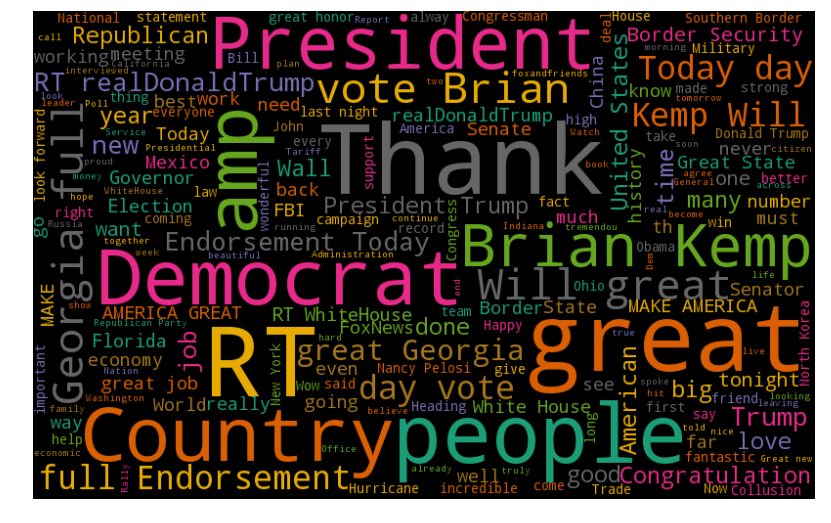

In [61]:
all_words = ' '.join([text for text in Tweets['absolute_tidy_tweets'][Tweets.sentiment == 'pos']])
generate_wordcloud(all_words)

### Most common words in negative tweets

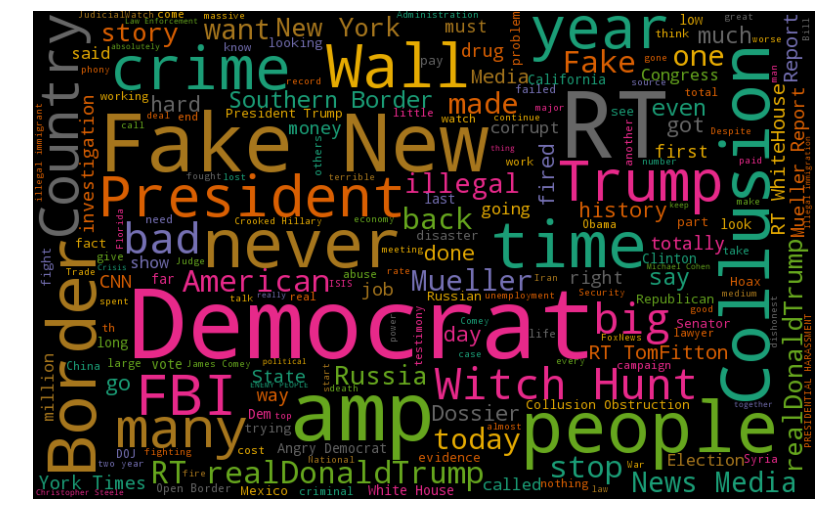

In [69]:
all_words = ' '.join([text for text in Tweets['absolute_tidy_tweets'][Tweets.sentiment == 'neg']])
generate_wordcloud(all_words)

## Feature Extraction

1. Bag of words (Simple vectorization)
2. TF-IDF (Term Frequency - Inverse Document Frequency)

#### Feature extraction for 'Key words'

In [85]:
# BOW
bow_word_vectorizer = CountVectorizer(max_df = 0.9, min_df=2, stop_words='english')
bow_word_feature = bow_word_vectorizer.fit_transform(Tweets['absolute_tidy_tweets'])


In [88]:
# TF-IDF 
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english')
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(Tweets['absolute_tidy_tweets'])

#### Feature extraction for 'Key phrases'

In [90]:
phrase_sents = Tweets['key_phrases'].apply(lambda x: ' '.join(x))

In [91]:
# BOW
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

In [92]:
# TF-IDF
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

## Model Building: Sentiment Analysis

In [93]:
# map target variables to {0, 1}
target_variable = Tweets['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

In [94]:
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()


In [95]:
def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)

    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)

#### Prediction on 'key words' based features

#### BOW

Accuracy Score - 0.6608427543679343


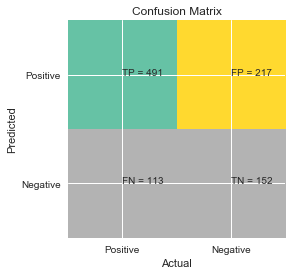

In [98]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

#### TF-IDF

Accuracy Score - 0.6649537512846866


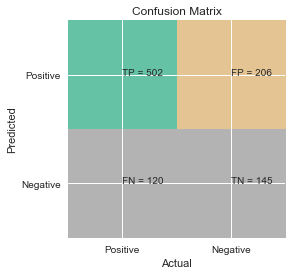

In [99]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

#### Predictions on 'key phrases' based features

#### BOW

Accuracy Score - 0.591983556012333


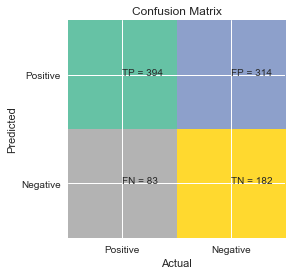

In [100]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

#### TFIDF

Accuracy Score - 0.5899280575539568


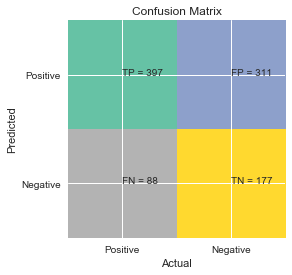

In [101]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)